# Preprocess Tutorial

You have successfully designed a scRNA-seq experiment - you isolated single cells, captured their transcripts, and generated sequencing libraries where the transcripts were mapped to individual cells. Now you have raw data in the form of a counts matrix. So, what do we do with this counts matrix? How can we use this data to start to answer interesting biological questions and even generate new hypotheses?

This series of scRNA-seq tutorials - Preprocess, Cluster Analysis, and Pseudotime Analysis - will take you through a standard scRNA-seq analysis workflow geared toward developmental biologists. Bioinformatics is a big field, and new and exciting methods and advancements are coming out all the time. Therefore, it is - quite frankly - impossible to cover everything in a single workshop (or even a full semester-long course!). However, these tutorials will serve as a great foundation for most scRNA-seq analyses.

These tutorials assume that upstream preprocessing has been completed. This includes base calling, mapping, and read counting, which is frequently handled by the 10x Genomics analysis pipeline Cell Ranger.

This notebook is largely adapted from the Seurat Vignettes [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html) and [Using sctransform in Seurat](https://satijalab.org/seurat/articles/sctransform_vignette.html) by Christoph Hafemeister & Rahul Satija with addtions from Caitlin's preprocess_tutorial.ipynb which is largely adapted from 
an [ipython notebook](https://github.com/theislab/single-cell-tutorial) provided by the Theis Lab as part of their Molecular Systems Biology submission "Current best practices in single‐cell RNA‐seq analysis: a tutorial" ([Luecken and Theis, 2019](https://doi.org/10.15252/msb.20188746)), as well as the basic scanpy [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. The original vignettes, notebooks and paper are worth checking out to get a more in-depth idea of the steps involved with scRNA-seq analysis (and the "best" ways to do them!). We also heavily utilized Bioconductor's online book [*Orchestrating Single-Cell Analysis with Bioconductor*](https://bioconductor.org/books/release/OSCA/) for some of the conceptual explanations. This is a fantastic resource to take a deeper dive into the various steps of scRNA-seq analysis (and is great if you are doing your scRNA-seq analysis in R!).)

For the first two tutorials - Preprocess and Cluster Analysis - we will be working with a publicly available scRNA-seq dataset that consists of *3k PBMCs from a Healthy Donor*, which is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). For this Seurat tutorial you will need to download the dataset.  

## Downloading the data

Follow these steps to create a folder for your single cell data and place the PBMCs dataset in it.  These steps walk you through creating folders from the jupyter notebook.  You can also create them with your Finder App (Windows equivalent?).

1. Navigate to the workspace/seurat folder where this preprocess_tutorial.ipynb resides from the left menu in the Jupyter notebook.  You can move up and down the folder structure by clicking on the folder names in the menu.

2. Click the New Folder icon at the top of this left side menu -- it's the folder with a plus sign in it. Name your folder data and hit enter.

3. Click on the newly created data folder to navigate to it and repeat the above process to create a folder called pbmc3k.  If you have additional datasets you wish to upload you can simply create folders for those additional datasets as well.

4. Using your Finder App (Windows equivalent??) move the pbmc3k_filtered_gene_bc_matrices.tar.gz file you downloaded to the workspace/seurat/data/pbmc3k folder and then unzip the file with your Archive Utility.  You should now have a folder workspace/seurat/data/pbmc3k/filtered_gene_bc_matrices/hg19/ with three files barcodes.txv, genes.tsv and matrix.mtx

# Table of Contents

* [1 10x Data](#1-10x-Data)
* [2 Setting up the Coding Environment](#2-Setting-up-the-Coding-Environment)
* [3 Reading in the Data](#3-Reading-in-the-Data)
* [4 Quality Control](#4-Quality-Control)
    - [Calculating QC Metrics](#Calculating-QC-Metrics)
    - [Plotting QC Metrics](#Plotting-QC-Metrics)
        - [Violin Plots](#Violin-Plots)
        - [Seurat FeatureScatter](#Seurat-FeatureScatter)
        - [Scatter Plots with ggplot](#Scatter-Plots-with-ggplot)
    - [Filtering Cells](#Filtering-Cells)
* [5 Normalization](#5-Normalization)
    - [Basic Normalization, Highly Variable Genes & Scaling](#Basic-Normalization,-Highly-Variable-Genes-&-Scaling)
        - [Log Normalize](#Log-Normalize)
        - [Identification of highly variable features (feature selection)](#Identification-of-highly-variable-features-(feature-selection))
        - [Scaling the data](#Scaling-the-data)
    - [SCTransform](#SCTransform)
* [6 Visualization](#6-Visualization)
    - [PCA](#PCA)
    - [UMAP and tSNE plots](#UMAP-and-tSNE-plots)
* [7 Saving Results](#7-Saving-Results)

# 1 10x Data

The first thing we need to do is understand what our 10x data looks like. After you submit your sample for sequencing, you will get your data back in the form of FastQ files (for the official FastQ file documentation, click [here](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=BlastHelp)). These FastQ files are passed to upstream processing pipelines like Cell Ranger, which take care of base calling, mapping, and read counting. The main output of Cell Ranger that you will work with for downstream analysis consists of three files:
* *matrix.mtx.gz*: the counts matrix (stored in Market Exchange Format for sparse matrices)
* *features.tsv.gz*: the features (usually genes) that correspond to the row indices in the counts matrix; for each feature, its feature ID and name are stored in the first and second column of the file
* *barcodes.tsv.gz*: the barcode sequences (i.e., the cell IDs), which correspond to column indices in the counts matrix

Downstream processing tools like scanpy and seurat take these three files and use them to construct a scRNA-seq analysis object (an *AnnData* object in scanpy, which stands for *Annotated Data*, and a *SeuratObject* in seurat). It's important to note that, while an *AnnData* object and a *SeuratObject* hold the same gene expression information, the format of the objects differ. An *AnnData* object stores scRNA-seq data in cells x genes format (i.e., the rows of the counts matrix correspond to the cells, and the columns of the counts matrix correspond to the genes). A *SeuratObject* stores scRNA-seq data in genes x cells format (i.e., the rows of the counts matrix correspond to the genes, and the columns of the counts matrix correspond to the cells). Data on GEO is also typically stored in genes x cells format, which would need to be transposed to cells x genes format to use with scanpy.

Note that the pbmc3k files we downloaded are named slightly differently.  They are not gzipped (.gz) and *features.tsv* is called *genes.tsv*.  These are an older 10X Genomics naming format.  Seurat will be able to recognize this old format so there's nothing you need to change, just wanted you to know why the file names are not quite the same.

# 2 Setting up the Coding Environment

In order to perform a scRNA-seq analysis, we need to set up our coding environment (this Jupyter notebook!). This involves loading all of the R packages we need via the [`library`](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/library) statement. An R package includes R code that can define functions, classes and variables, the documentation that describes how to use the functions, and sample data.  For example, [`Seurat`](https://satijalab.org/seurat/index.html) is an R package designed for QC, analysis, and exploration of single-cell RNA-seq data.  Here are some other R packages we will use in this single-cell RNA-seq analysis.  The package [`dplyr`](https://dplyr.tidyverse.org) provides easy tools for the most common data wrangling tasks. It is built to work directly with dataframes, with many common tasks optimized by being written in a compiled language (C++) (not all R packages are written in R!).  The package [`tidyr`](https://tidyr.tidyverse.org) addresses the common problem of wanting to reshape your data for plotting and use by different R functions. Sometimes we want data sets where we have one row per measurement. Sometimes we want a dataframe where each measurement type has its own column, and rows are instead more aggregated groups. Moving back and forth between these formats is nontrivial, and tidyr gives you tools for this and more sophisticated data wrangling.  The package [`ggplot2`](https://ggplot2.tidyverse.org) is the commonly used R plotting package.  Seurat plots are ggplots.  You don't need to load ggplot to create Seurat plots but it is necessary if you want to modify the plot, for instance, adding a title.  The package [`patchwork`](https://patchwork.data-imaginist.com) addresses plot layout and makes it simple to print multiple plots together.  The package [`ggsci`](https://nanx.me/ggsci/) offers a collection of ggplot2 color palettes inspired by scientific journals, data visualization libraries, science fiction movies, and TV shows.  The package [`readxl`](https://readxl.tidyverse.org) is used to read data in Excel format into R.

Once a package has been loaded into our environment, all the functions defined in the package are available to use by typing the name of the function, for instance, `DimPlot` is a function of `Seurat` used to plot cells in reduced dimensional space.  Help documentation which is useful for viewing available arguments and format for functions is available for all the functions in a loaded package and can be acessed using `help()` or `?`.

Note: We are using a Jupyter notebook for this workshop to keep a consistent coding environment whether you are using python and [`scanpy`] or R and [`Seurat`] but [`RStudio`](https://www.rstudio.com) is a commonly used environment for running R packages.  All the code in this notebook will work in both Jupyter and RStudio.  In RStudio in addtion to `help()` or `?` help for each function is available in the Files/Plots/Packages/Help/Viewer Pane of RStudio.  

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(ggsci)
library(readxl)
library(tidyr)
#options(future.globals.maxSize = 4000 * 1024^2)  Don't need this for this dataset, but if you have a large dataset you may need this


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
options(repr.plot.width=10, repr.plot.height=7)

Let's see the help documents for DimPlot.

In [3]:
?DimPlot
# help(DimPlot)
# you could run help(DimPlot) instead of ?DimPlot and that will return the same thing

DimPlot {Seurat},R Documentation
object,Seurat object
dims,"Dimensions to plot, must be a two-length numeric vector specifying x- and y-dimensions"
cells,Vector of cells to plot (default is all cells)
cols,"Vector of colors, each color corresponds to an identity class. This may also be a single character or numeric value corresponding to a palette as specified by brewer.pal.info. By default, ggplot2 assigns colors. We also include a number of palettes from the pals package. See DiscretePalette for details."
pt.size,Adjust point size for plotting
reduction,"Which dimensionality reduction to use. If not specified, first searches for umap, then tsne, then pca"
group.by,"Name of one or more metadata columns to group (color) cells by (for example, orig.ident); pass 'ident' to group by identity class"
split.by,Name of a metadata column to split plot by; see FetchData for more details
shape.by,"If NULL, all points are circles (default). You can specify any cell attribute (that can be pulled with FetchData) allowing for both different colors and different shapes on cells. Only applicable if raster = FALSE."
order,Specify the order of plotting for the idents. This can be useful for crowded plots if points of interest are being buried. Provide either a full list of valid idents or a subset to be plotted last (on top)


# 3 Reading in the Data

We start by reading in the data. The `Read10X()` function reads in the output of the cellranger pipeline from 10X, returning a
unique molecular identified (UMI) count matrix. The values in this matrix represent the number of molecules for each feature
(i.e. gene; row) that are detected in each cell (column).
We next use the count matrix to create a Seurat object. The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for a single-cell dataset. For a technical discussion of the Seurat object structure, check out the [Seurat GitHub Wiki](https://github.com/satijalab/seurat/wiki). For example, the count matrix is stored in pbmc[["RNA"]]@counts .

In [5]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "data/pbmc3k/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


We now have a seurat object, which we are calling pbmc. You can call your seurat object anything you want, but it's best to use something short and descriptive.  Remember R variables must start with a character not a number, so pbmc is OK but 3kpbmc is not.

In [6]:
# If we look at our seurat object, you can see that we have 13714 features (in this case genes) x 2700 samples (cells)
# with one assay called RNA
pbmc

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

The meta.data of a SeuratObject stores information about each cell.  It is stored in `pbmc@meta.data`.  When creating a SeuratObject the meta.data is populated with the orig.ident (project in `CreateSeuratObject()`, nCount_RNA (the total UMI count for the cell) and nFeature_RNA (the total feature, in this case, gene count for the cell).

In [7]:
head(pbmc@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACAACCAC-1,pbmc3k,2419,779
AAACATTGAGCTAC-1,pbmc3k,4903,1352
AAACATTGATCAGC-1,pbmc3k,3147,1129
AAACCGTGCTTCCG-1,pbmc3k,2639,960
AAACCGTGTATGCG-1,pbmc3k,980,521
AAACGCACTGGTAC-1,pbmc3k,2163,781


# 4 Quality Control

Quality control can be split into two main parts: cell QC and gene QC. 

Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell (though, it should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration). Therefore, the most common quality control is to filter out: 1) cells with too few genes detected (these usually represent cells which are not sequenced deep enough for reliable characterization), 2) cells with too many genes detected (doublets!), and 3) cells with high mitochondrial transcript percentage.

For gene QC, it is typically a good idea to filter out genes that are detected in a low number of cells as these are unlikely to be informative. 

Note: there is no one-size-fits-all filtering criteria. It's best to *only filter out outlier cells*, i.e. the minority of cells with certain QC metrics clearly above or below the majority of cells. In general, it is good practice to be permissive in the early filtering steps. After doing some initial visualization and clustering you can re-assess your data and determine if more stringent filtering is needed.

## Calculating QC Metrics

Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. 
We calculate mitochondrial QC metrics with the `PercentageFeatureSet()` function, which calculates the percentage of counts originating from a set of features.  We use the set of all genes starting with MT- as a set of mitochondrial genes.

In [8]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [9]:
head(pbmc@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551


## Plotting QC Metrics

### Violin Plots

We can use a violin plot to visualize the *nFeatures_RNA* (number of genes), *nCount_RNA* (total UMI count) and *percent.mt* for all cells.

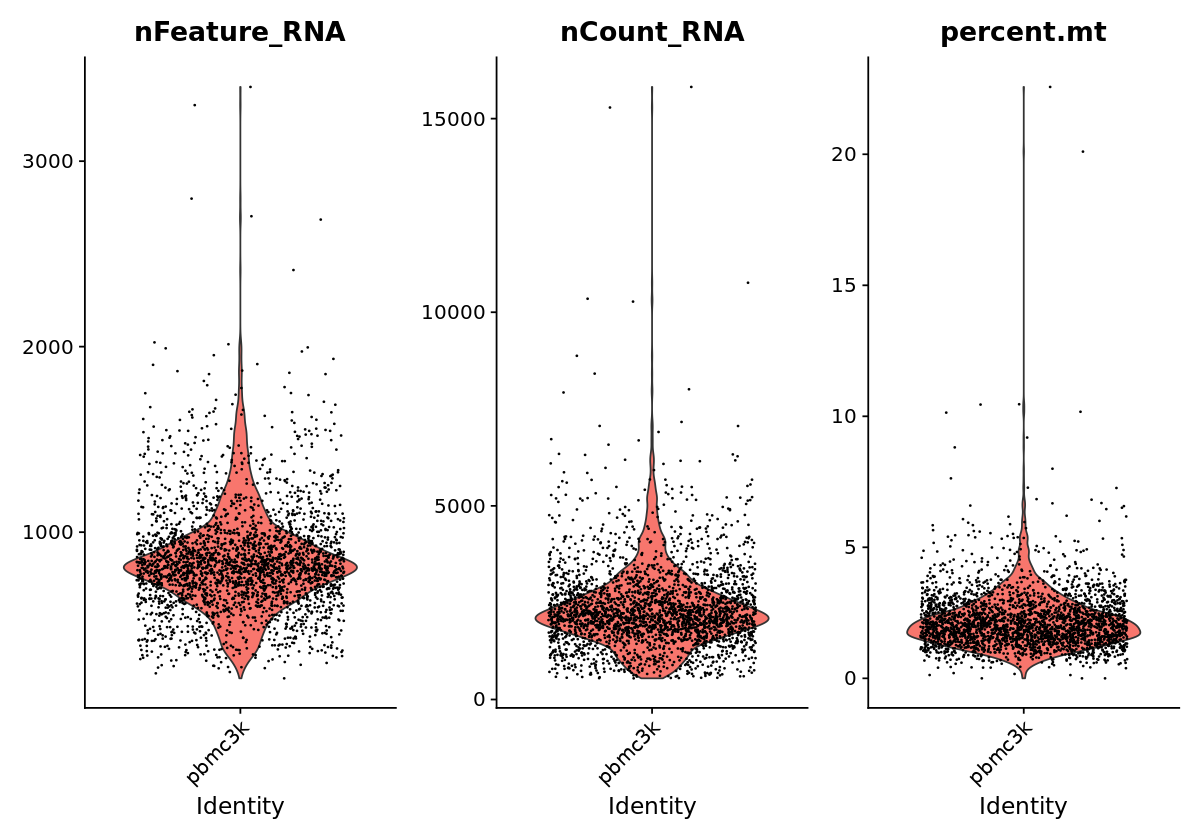

In [10]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

### Seurat FeatureScatter

`Seurat` also has `FeatureScatter()` for visualizing QC metrics.

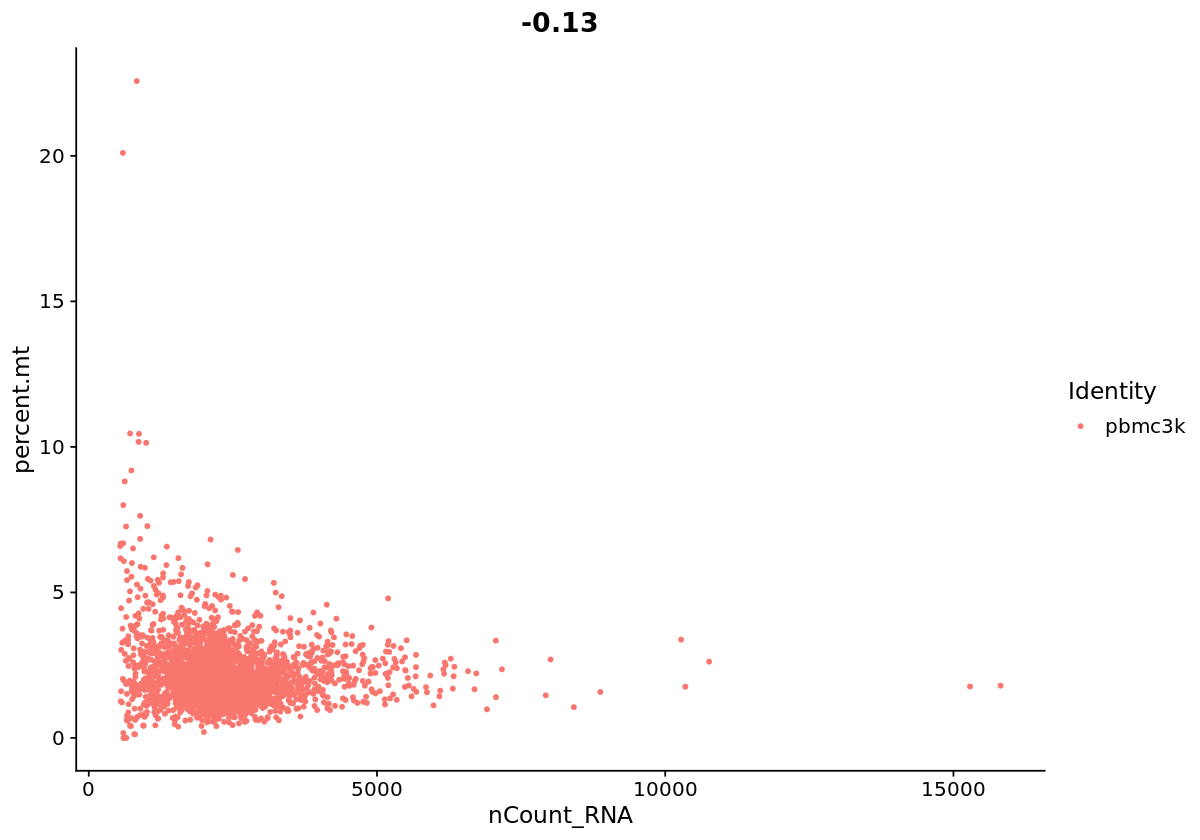

In [11]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot1


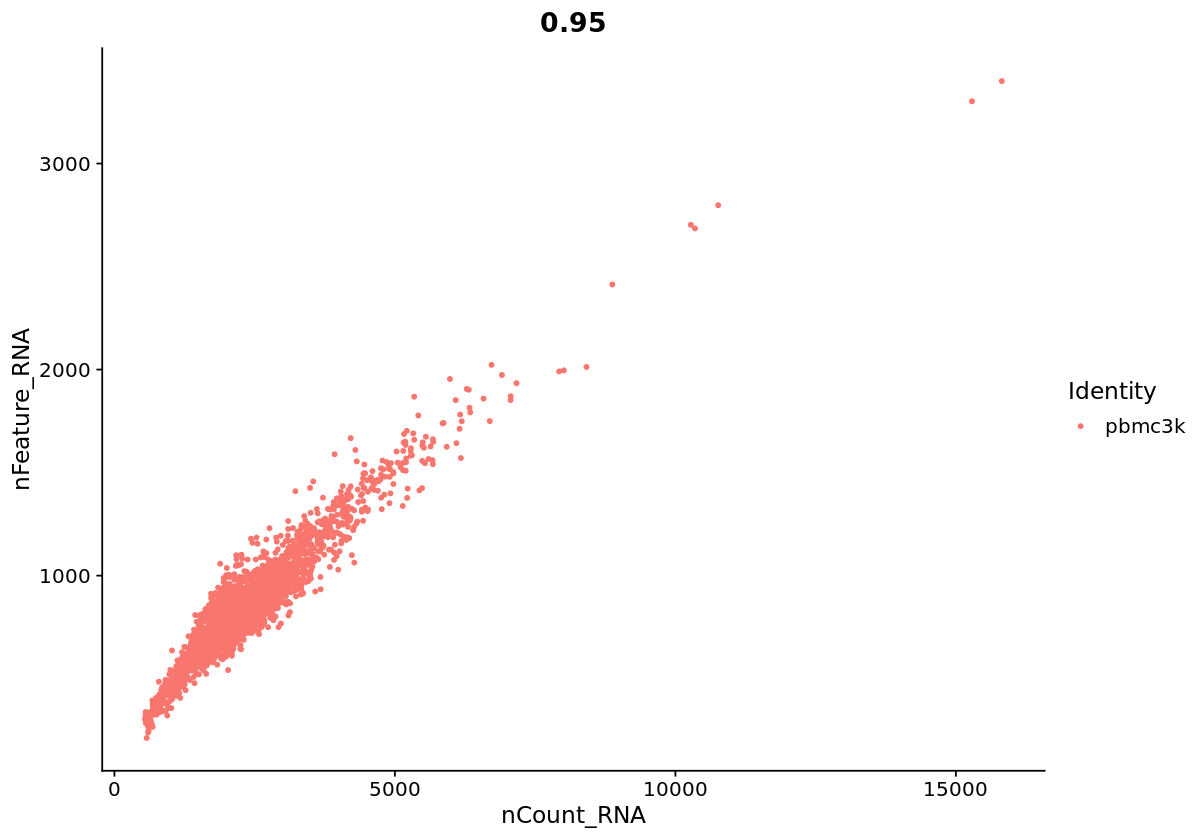

In [12]:
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot2

### Scatter Plots with ggplot

I prefer the following QC plots which are not part of `Seurat`.

The first is a scatter plot like plot2 above but colored by percent.mt

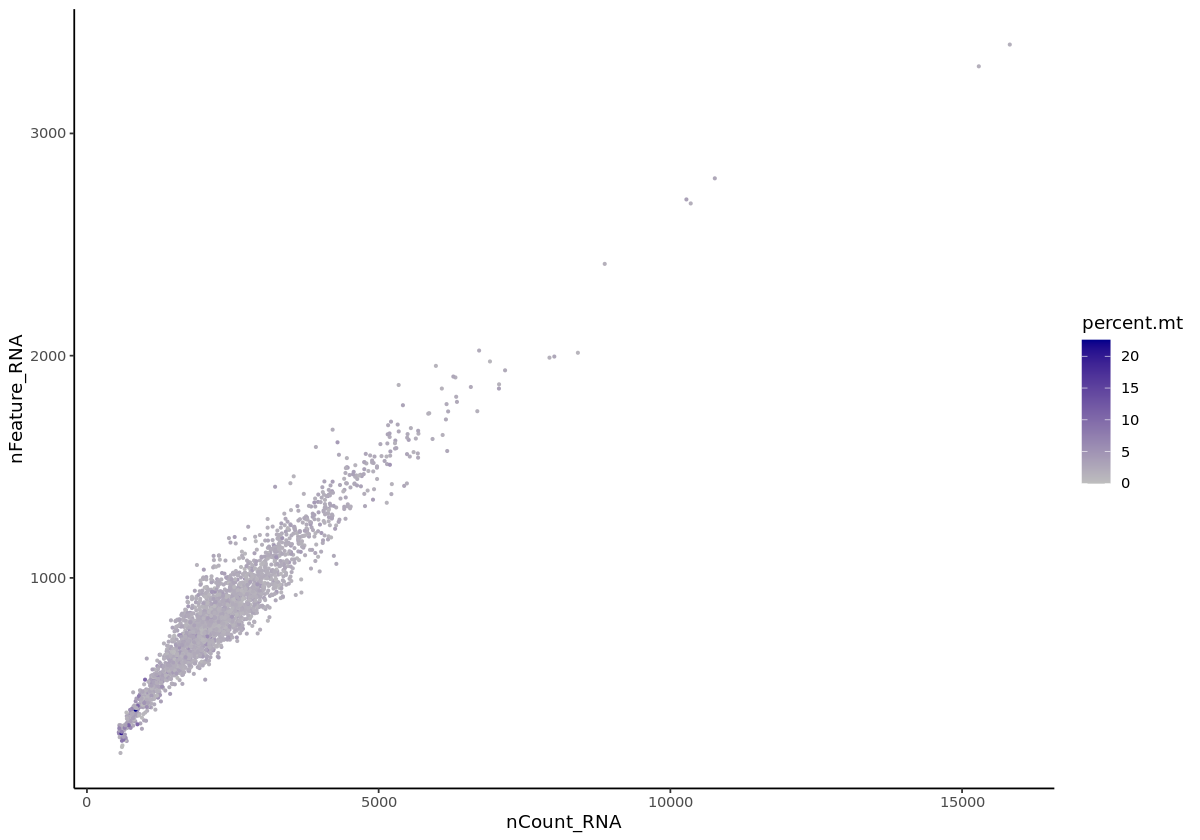

In [13]:
qc1 <- ggplot(pbmc@meta.data, aes(x=nCount_RNA, y=nFeature_RNA, color=percent.mt)) + 
    geom_point(size=0.5) +
    scale_color_gradient(low="grey",high="darkblue") + theme_classic()
qc1

The next 2 plots are similar to plot1 and plot2 but use log scale and add density contour lines.

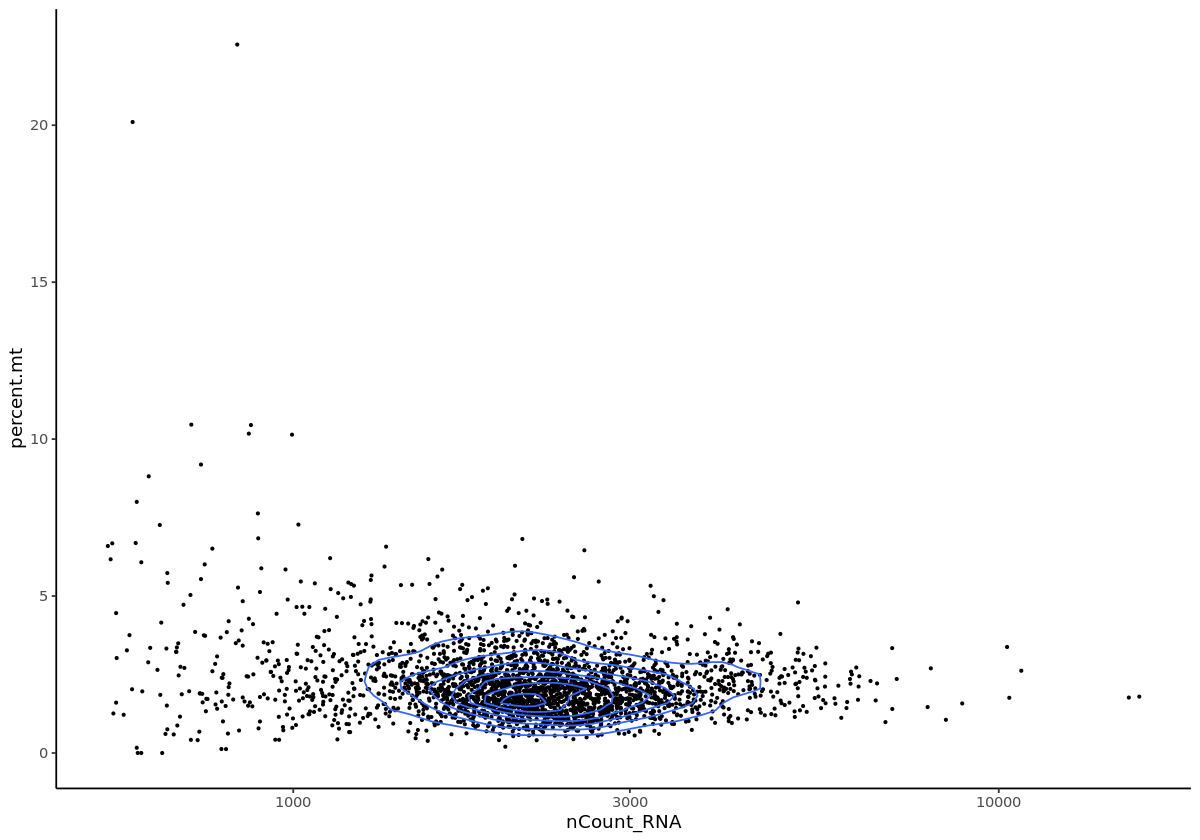

In [14]:
qc2 <- ggplot(pbmc@meta.data, aes(x=nCount_RNA, y=percent.mt)) + 
    geom_point(size=0.5) + scale_x_log10() +
    geom_density2d() + theme_classic()
qc2

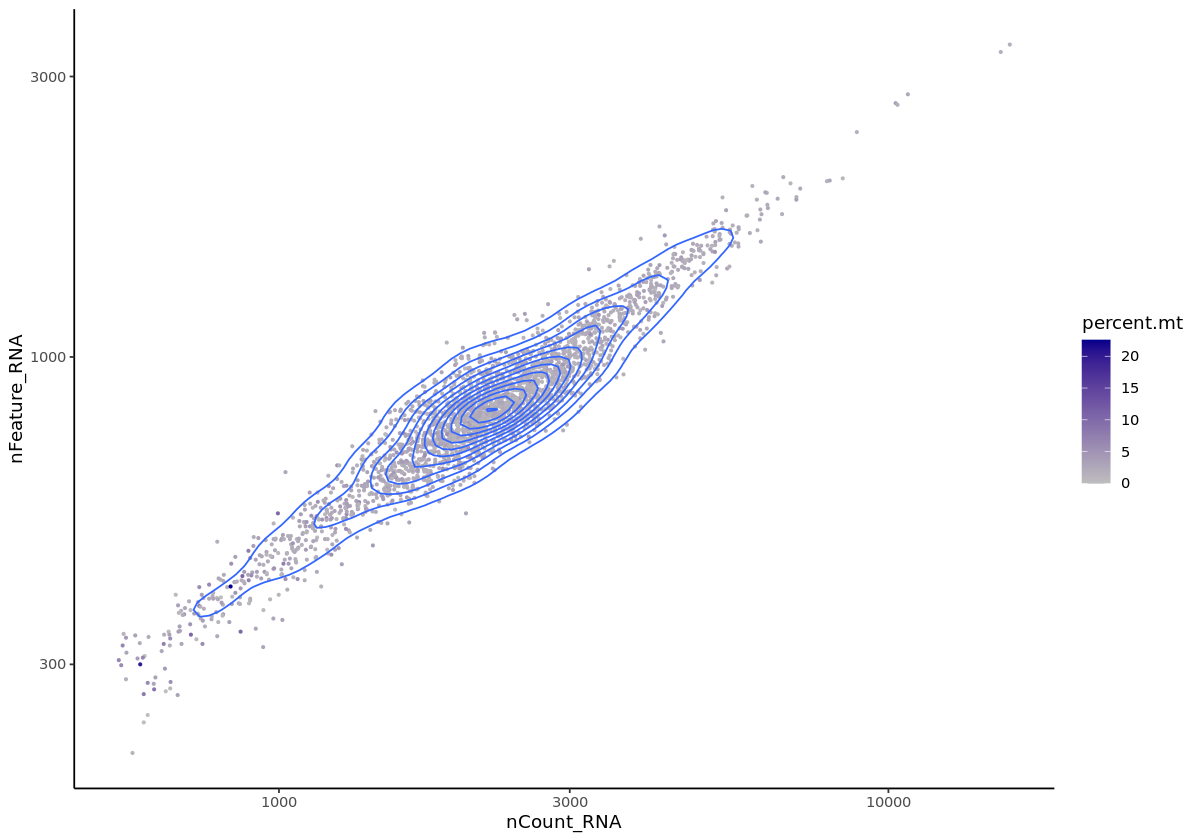

In [15]:
options(repr.plot.width=10, repr.plot.height=7)
qc3 <- ggplot(pbmc@meta.data, aes(x=nCount_RNA, y=nFeature_RNA ,color=percent.mt)) + 
    geom_point(size=0.5) +
    scale_x_log10() + scale_y_log10() + geom_density2d() +
    scale_color_gradient(low="gray",high="darkblue") + theme_classic()
qc3

## Filtering Cells

We filter cells that have unique feature counts over 2,500 or less than 200 and filter cells that have >5% mitochondrial counts.

In [16]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# 5 Normalization

In scRNA-seq analyses we can't just take the raw read counts to compare gene expression between cells because the raw read counts are confounded by technical and 'uninteresting' biological variations, primarily due to differences in sequencing depth (the number of reads obtained, also called *library size*; sequencing depth can vary by orders of magnitude across different cells in a scRNA-seq dataset), but also due to differences in cell lysis and reverse transcription efficiency. The goal of normalization is to remove the influence of these confounding factors while preserving true biological heterogeneity (i.e., adjust the dataset such that the variance of a gene is independent of gene abundance and sequencing depth of a cell).

So how do we normalize our dataset? Seurat offers two normalization methods.

## Basic Normalization, Highly Variable Genes & Scaling

The first method uses `NormalizeData()` followed by `FindVariableFeatures()` and `ScaleData()`.  For demonstration purposes, we will first normalize this pbmc data using this method because it clearly demonstrates the various steps used in normalization.  **However, we will be saving the "pbmc" normalized in this way as a new SeuratObject called "pbmc.normtest" but not using this SeuratObject in the rest of the notebook.** 

### Log Normalize

By default, `Seurat` employs a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in pbmc[["RNA"]]@data.

In [17]:
## Seurat functions which modify the SeuratObject take the SeuratObject as input and then return
## a SeuratObject.  Typically you would use the same name for the returned object as the input.  In
## this case we will return the LogNormalized SeuratObect to a new name "pbmc.normtest".  In this way
## our original SeuratObject "pmbc" will remain unmodified and we can then normalize it with the
## SCTransfom() function below.

pbmc.normtest <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Note the above code specifies default parameters that are technically unnecessary.  However, it is useful in this tutorial as well as in your actual analyses to specify these parameters even when they are the default settings to make it clear what parameters have been used.  The above code is idential to:

In [18]:
pbmc.normtest <- NormalizeData(pbmc)

### Identification of highly variable features (feature selection)

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). Seurat developers and others have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

The procedure in Seurat is described in detail [here](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub), and improves on previous versions by directly modeling the mean-variance relationship inherent in single-cell data, and is implemented in the `FindVariableFeatures()` function. By default, this returns 2,000 features per dataset. These will be used in downstream analysis, like PCA.

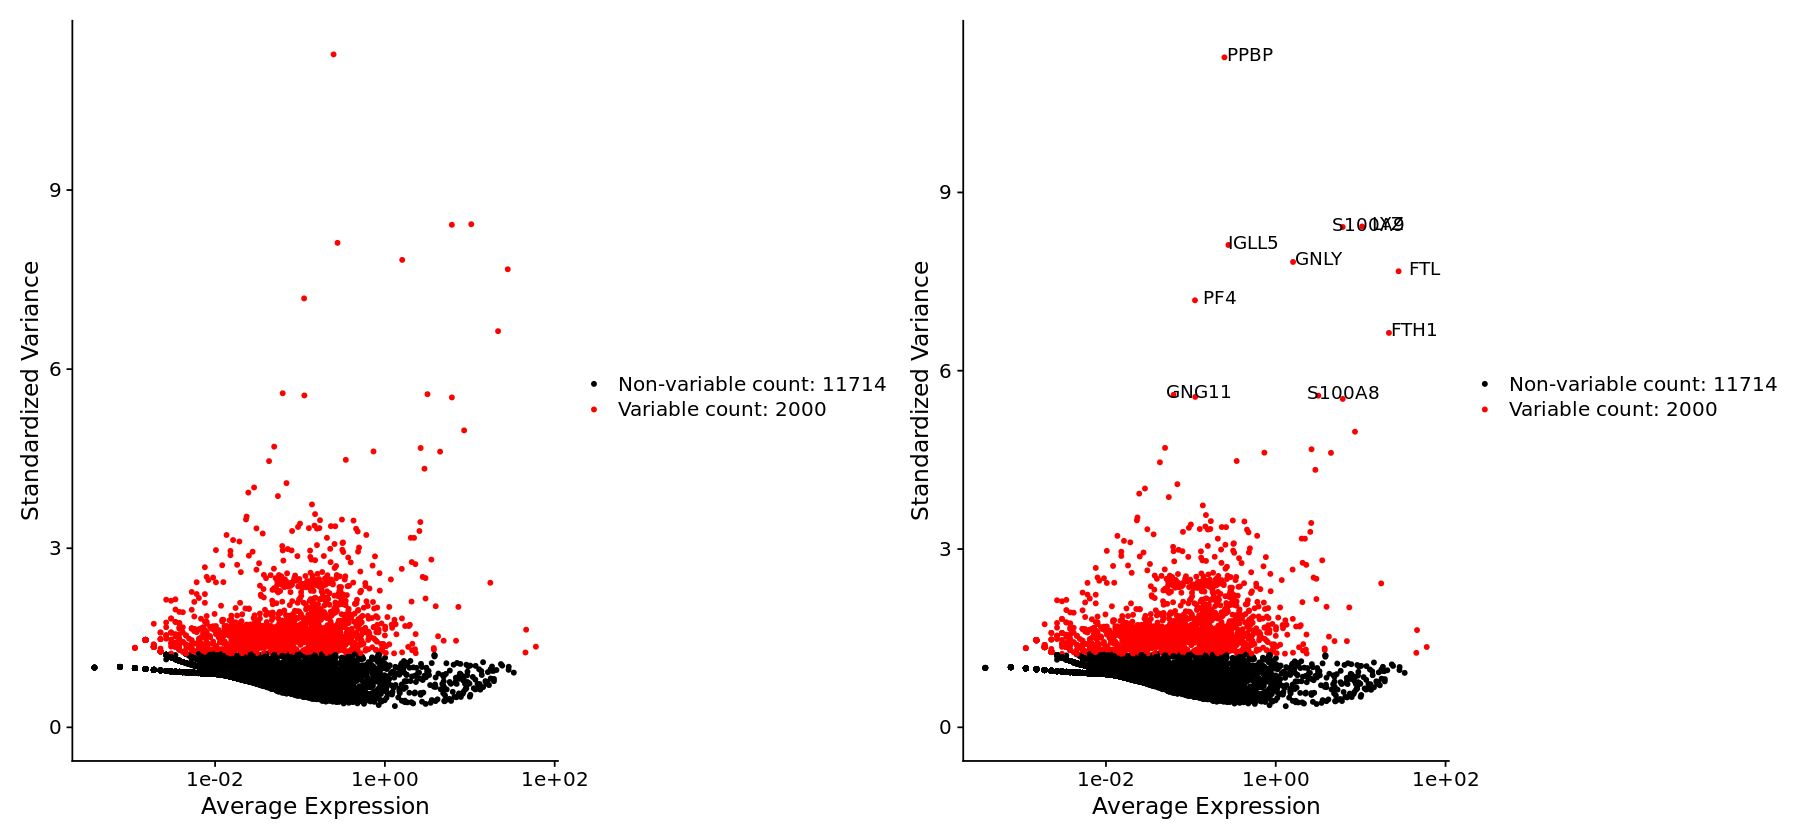

In [19]:
options(warn=-1,repr.plot.width=15, repr.plot.height=7) ## this removes warning messages and sets plot size
pbmc.normtest <- FindVariableFeatures(pbmc.normtest, selection.method = "vst", nfeatures = 2000)

## Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc.normtest), 10)

## plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc.normtest)
plot2 <- LabelPoints(plot = plot1, points = top10)
plot1 + plot2

### Scaling the data

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The `ScaleData()` function:

* Shifts the expression of each gene, so that the mean expression across cells is 0
* Scales the expression of each gene, so that the variance across cells is 1
    * This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
* The results of this are stored in pbmc[["RNA"]]@scale.data

In [20]:
all.genes <- rownames(pbmc.normtest)
pbmc.normtest <- ScaleData(pbmc.normtest, features = all.genes)

Centering and scaling data matrix



In [21]:
rm(pbmc.normtest)

## SCTransform

The second `Seurat` normalization method is `SCTransform`. Biological heterogeneity in single-cell RNA-seq data is often confounded by technical factors including sequencing depth. The number of molecules detected in each cell can vary significantly between cells, even within the same celltype. Interpretation of scRNA-seq data requires effective pre-processing and normalization to remove this technical variability. In [Hafemeister and Satija, 2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) the Seurat developers introduce a modeling framework for the normalization and variance stabilization of molecular count data from scRNA-seq experiment. This procedure omits the need for heuristic steps including pseudocount addition or log-transformation and improves common downstream analytical tasks such as variable gene selection, dimensional reduction, and differential expression. 

* Note that this single command `SCTransform` replaces `NormalizeData()`, `ScaleData()`, and `FindVariableFeatures()`.
* Transformed data will be available in the SCT assay (as opposed to the RNA assay), which is set as the default after running sctransform
* During normalization, we can also remove confounding sources of variation, for example, mitochondrial mapping percentage

Note that we are starting with the "pbmc" SeuratObject and will be saving the returned SeuratObject with same name "pbmc" because this is the normalization method we want to use in this notebook analysis.

In [22]:
options(warn=-1)
pbmc <- SCTransform(pbmc, vars.to.regress = "percent.mt", verbose = FALSE)

The latest version of sctransform also supports using [glmGamPoi](https://bioconductor.org/packages/release/bioc/html/glmGamPoi.html) package which substantially improves the speed of the learning procedure. It can be invoked by specifying method="glmGamPoi".

In [23]:
#if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")

#BiocManager::install("glmGamPoi")
#pbmc <- SCTransform(pbmc, method = "glmGamPoi", vars.to.regress = "percent.mt", verbose = FALSE)

# 6 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. It is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. For instance, tsne plots provide great visualization when cells form distinct cell groups, while umap plots preserve trajectory-like structure better. Again, there are no "right" answers!

If you're following along and comparing the `scanpy` and `Seurat` tutorials you will note that the `scanpy` data are not scaled while the `Seurat` data are.  

In order to visualize our scRNA-seq data, we'll first reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data. By definition, the top principal components (PCs) capture the dominant factors of heterogeneity in the dataset. We can perform dimensionality reduction by restricting downstream analyses to the top PCs. How many PCs should we use? There is no simple answer (again, it depends on your unique dataset), but generally using more PCs will retain more biological signal at the cost of including more noise that might mask said signal. Generally, people will use a reasonable but arbitrary value of PCs, ranging from 10 to 50. You can read more about dimensionality reduction [here](https://bioconductor.org/books/release/OSCA/dimensionality-reduction.html#choosing-the-number-of-pcs). Also, [this](https://www.youtube.com/watch?v=FgakZw6K1QQ&t=0s) video does a great job of breaking down PCA one step at a time.

## PCA

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset.

In [ ]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Seurat provides several useful ways of visualizing both cells and features that define the PCA, including VizDimLoadings(), DimPlot(), and DimHeatmap()

In [ ]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

In [ ]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

In [ ]:
DimPlot(pbmc, reduction = "pca")

In particular `DimHeatmap()` allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting cells to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.

In [ ]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

In [ ]:
options(repr.plot.width=10, repr.plot.height=20)
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

An `Elbow plot()` produces a plot ranking principle components based on the percentage of variance explained by each one. In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

In [ ]:
options(repr.plot.width=10, repr.plot.height=7)
ElbowPlot(pbmc, ndims=30)

### A note on SCTransform vs NormalizeData/FindVariableFeatures/ScaleData concerning the number of variable features and PCs

In the [standard Seurat workflow](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html) the Seurat developers focus on 10 PCs for this dataset, though they highlight that the results are similar with higher settings for this parameter. Interestingly, they’ve found that when using `SCTransform`, analysis often benefits by pushing this parameter even higher. They believe this is because the sctransform workflow performs more effective normalization, strongly removing technical effects from the data.

Even after standard log-normalization, variation in sequencing depth is still a confounding factor (see [Figure 1](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)), and this effect can subtly influence higher PCs. In sctransform, this effect is substantially mitigated (see [Figure 3](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)). This means that higher PCs are more likely to represent subtle, but biologically relevant, sources of heterogeneity – so including them may improve downstream analysis.

In addition, `SCTransform` returns 3,000 variable features by default, instead of 2,000. The rationale is similar, the additional variable features are less likely to be driven by technical differences across cells, and instead may represent more subtle biological fluctuations. In general, they find that results produced with `SCTransform` are less dependent on these parameters (indeed, they achieve nearly identical results when using all genes in the transcriptome, though this does reduce computational efficiency). This can help users generate more robust results, and in addition, enables the application of standard analysis pipelines with identical parameter settings that can quickly be applied to new datasets.

## UMAP and tSNE plots

Seurat offers several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets. The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. **As input to the UMAP and tSNE, the Seurat developers suggest using the same PCs as input to the clustering analysis.**. If ever you have cells assigened to clusters that seem to agree poorly with your UMAP/tSNE plot, double check that you've used the same number of PCs in `FindNeighbors()` as `RunUMAP()` or `RunTSNE()`.  Since we have normalized this data with `SCTransform()` we will use the first 30 PCs.

In [ ]:
pbmc <- RunUMAP(pbmc, dims = 1:30)  ## you can add verbose=FALSE to prevent the processing messages printing

In [ ]:
pbmc <- RunTSNE(pbmc, dims = 1:30)

We can use `FeaturePlot()` to plot the cells as UMAP or tSNE and color by any column in the meta.data table.  `patchwork` allows us to plot the 4 individual plots as one using the format p1 + p2 + p3 + p4.

In [ ]:
options(repr.plot.width=10, repr.plot.height=15)
p1 <- FeaturePlot(pbmc, features = "nCount_RNA", reduction = 'umap')
p2 <- FeaturePlot(pbmc, features = "nFeature_RNA", reduction = 'umap')
p3 <- FeaturePlot(pbmc, features = "nCount_RNA", reduction = 'tsne')
p4 <- FeaturePlot(pbmc, features = "nFeature_RNA", reduction = 'tsne')
p1 + p2 + p3 + p4

Let's arrange the above plots in two columns.  This is done with the `plot_layout()` function from `patchwork`.  Also, instead of the grey to blue default `Seurat` color scale, let's use the viridis color scale.  The colors in this plot are a continuous scale, so we'll use viridis_c. The [viridis scales](https://bids.github.io/colormap/) provide colour maps that are perceptually uniform in both colour and black-and-white. They are also designed to be perceived by viewers with common forms of colour blindness. 

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
p1 <- FeaturePlot(pbmc, features = "nCount_RNA", reduction = 'umap') + scale_color_viridis_c()
p2 <- FeaturePlot(pbmc, features = "nFeature_RNA", reduction = 'umap') + scale_color_viridis_c()
p3 <- FeaturePlot(pbmc, features = "nCount_RNA", reduction = 'tsne') + scale_color_viridis_c()
p4 <- FeaturePlot(pbmc, features = "nFeature_RNA", reduction = 'tsne') + scale_color_viridis_c()
p1 + p2 + p3 + p4 + plot_layout(ncol = 2)

# 7 Saving Results

Create a new directory in workspace/seurat and call it: output

Now we can save our SeuratObject as an RDS object so we can use it for clustering in the next tutorial.

In [ ]:
saveRDS(pbmc, file = "output/pbmc.RDS")

If you'd like to save an .html file containing your jupyter notebook with all Rmarkdown documentation, code and results you can use the jupyter commmand nbconvert with your jupyter notebook name and file format to convert to; in this case, html.  Since we are running R and this is a bash command, this all needs to go inside the R base function `system()`.

In [ ]:
system("jupyter nbconvert preprocess_tutorial_seurat.ipynb --to html", intern=TRUE)